---
title: "Efficient Inference for ModernBERT Classifiers Using vLLM "
description: "Modern Inference for modern models. Using vLLM to scale ModernBERT based classifier models to clean and curate datasets"
author: "Daniel van Strien"
date: "2025-04-24"
categories: ["huggingface", "datasets", "arxiv", "vllm", "modernbert"]
image: https://github.com/davanstrien/blog/raw/refs/heads/main/posts/2025/vllm/vllm-modernbert.png
twitter-card:
  title: "Efficient Inference for ModernBERT Classifiers Using vLLM "
  description: "Modern Inference for modern classifier models. Using vLLM to scale inference for classifiers to clean and curate datasets"
  image: https://github.com/davanstrien/blog/raw/refs/heads/main/posts/2025/vllm/vllm-modernbert.png
  card-style: summary_large_image
open-graph:
  title: "Efficient Inference for ModernBERT Classifiers Using vLLM "
  description: "Modern Inference for modern classifier models. Using vLLM to scale inference for classifiers to clean and curate datasets"
  image: https://github.com/davanstrien/blog/raw/refs/heads/main/posts/2025/vllm/vllm-modernbert.png
toc-depth: 3
toc: true
---

# vLLM scaling inference beyond generative models

> *tl;dr* this blog post gives a quick overview of how to use vLLM to run inference for ModernBERT basesd classifier models.


[vLLM](https://vllm.ai/) is a very well known and heavily used inference engine. It is known for its ability to scale inference for LLMs.

vLLM has two major ways in which it can be used:

- OpenAI compatible inference API
- Offline batched inference

While the OpenAI endpoint is useful, for the kinds of work I am using LLMs for I am often relying on the batched offline inference. Combined with structured generation, offline inference using vLLM can be a super useful way of generating synthetic data. See this post on using [QWQ and Curator](https://danielvanstrien.xyz/posts/2025/reasoning-models/generating-structured-data-extraction-dataset-with-qwq-and-curator.html) as an example of this kind of approach.

### Support for ModernBert

Recently, vLLM [added](https://github.com/vllm-project/vllm/pull/16648) support for the ModernBERT arcitecture. This is great news for the community as it means that we can now use vLLM to scale inference for ModernBERT based classifier models.

::: {.callout-note}
If you haven't come across ModernBERT you may want to checkout this [post](https://huggingface.co/blog/modernbert) for a quick overview. The short verson is that ModernBERT is a modern architecture that is designed to be more efficient and effective than traditional BERT models while being useful for similar tasks to the original BERT models (including classification tasks).
:::

In the rest of this post, I'll give a quick overview of how to use vLLM to scale inference for ModernBERT based classifier models.

## Installation

Since we are using a feature not yet in a main release, we need to install the nightly version of vLLM. Using `uv` makes this very easy. We'll also install the `datasets` and `polars` libraries as we'll be using them to load and process our data.

In [1]:
# | output: false
%pip install uv
!uv pip install -U vllm datasets --extra-index-url https://wheels.vllm.ai/nightly

Streaming output truncated to the last 5000 lines.
nvidia-nvjitlink-cu12 ------------------------------ 4.23 MiB/20.09 MiB
nvidia-cuda-nvrtc-cu12 ------------------------------ 4.25 MiB/23.50 MiB
scipy      ------------------------------ 3.68 MiB/35.89 MiB
pyarrow    ------------------------------ 4.18 MiB/40.13 MiB
llvmlite   ------------------------------ 4.21 MiB/40.40 MiB
xformers   ------------------------------ 4.36 MiB/42.24 MiB
hf-xet     ------------------------------ 4.30 MiB/51.32 MiB
nvidia-curand-cu12 ------------------------------ 4.20 MiB/53.70 MiB
ray        ------------------------------ 4.32 MiB/64.59 MiB
cupy-cuda12x ------------------------------ 4.25 MiB/100.54 MiB
nvidia-cusolver-cu12 ------------------------------ 4.27 MiB/122.01 MiB
⠼ Preparing packages... (57/84)
openai     ------------------------------ 536.57 KiB/645.70 KiB
numba      ------------------------------ 2.79 MiB/3.65 MiB
uvloop     ------------------------------ 3.78 MiB/3.79 MiB
pillow     ------

Since I orginally ran this on Google Colab, I'll also grab the HF token from the user data (we will need a token if we are working with a private dataset/model or if we want to push the results back to the Hub).

In [1]:
from google.colab import userdata

hf_token = userdata.get("HF_TOKEN")

## The use case

Since it's not super imporant for the post, I'll keep it very brief but the use case I am working on is using ModernBERT to classify arXiv papers as containting new datasets. You can read about how I created the dataset in this [post](https://danielvanstrien.xyz/posts/2025/deepseek/distil-deepseek-modernbert.html#generating-labels). This results in [davanstrien/ModernBERT-base-is-new-arxiv-dataset](https://huggingface.co/davanstrien/ModernBERT-base-is-new-arxiv-dataset) a model that classifies papers as containing a new dataset or not.

Although we'll be using this model in this post, the same approach should work well with any ModernBERT based classifier model. This includes [these models](https://huggingface.co/models?pipeline_tag=text-classification&other=base_model:finetune:answerdotai%2FModernBERT-base&sort=trending) based on the base variant and [these models](https://huggingface.co/models?pipeline_tag=text-classification&other=base_model:finetune:answerdotai%2FModernBERT-large&sort=trending) based on the large variant.

## Loading the model

We'll now load the model using vLLM. This is very similar to loading any other model in `vllm`, the only difference is that we specify `task="classify"` to tell vLLM that we are using a
classifier model.

In [2]:
from vllm import LLM

llm = LLM(model="davanstrien/ModernBERT-base-is-new-arxiv-dataset", task="classify")

INFO 04-24 14:16:50 [__init__.py:239] Automatically detected platform cuda.


config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

INFO 04-24 14:16:59 [config.py:2888] Downcasting torch.float32 to torch.float16.
WARNING 04-24 14:17:13 [arg_utils.py:1685] --task classify is not supported by the V1 Engine. Falling back to V0. 
INFO 04-24 14:17:13 [llm_engine.py:242] Initializing a V0 LLM engine (v0.8.5.dev195+gc0dfd9751) with config: model='davanstrien/ModernBERT-base-is-new-arxiv-dataset', speculative_config=None, tokenizer='davanstrien/ModernBERT-base-is-new-arxiv-dataset', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, 

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

INFO 04-24 14:17:20 [cuda.py:295] Using Flash Attention backend.
INFO 04-24 14:17:20 [parallel_state.py:946] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 04-24 14:17:20 [model_runner.py:1120] Starting to load model davanstrien/ModernBERT-base-is-new-arxiv-dataset...
INFO 04-24 14:17:21 [weight_utils.py:265] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

INFO 04-24 14:17:25 [weight_utils.py:281] Time spent downloading weights for davanstrien/ModernBERT-base-is-new-arxiv-dataset: 3.888106 seconds
INFO 04-24 14:17:25 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 04-24 14:17:26 [loader.py:458] Loading weights took 0.18 seconds
INFO 04-24 14:17:26 [model_runner.py:1156] Model loading took 0.3098 GiB and 5.243792 seconds


Let's test the model out with a simple example.

In [3]:
(output,) = llm.classify(
    "Title: This paper introduces a new benchmark dataset shared on Zenodo"
)

probs = output.outputs.probs
print(f"Class Probabilities: {probs!r} (size={len(probs)})")

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Class Probabilities: [1.6357421875, -1.3671875] (size=2)


We can also get the top predicted class and confidence score.

In [4]:
import torch
import torch.nn.functional as F

logits = torch.tensor(output.outputs.probs)
probabilities = F.softmax(logits, dim=0)

# Get the top predicted class
top_idx = torch.argmax(probabilities).item()
top_prob = probabilities[top_idx].item()

print(f"Top class index: {top_idx}")
print(f"Confidence: {top_prob:.4f}")

Top class index: 0
Confidence: 0.9527


### Getting the labels

The outputs of vLLM don't contain the labels but we can easily grab them from the model configuration

In [5]:
import httpx
from huggingface_hub import hf_hub_url

id2label = (
    httpx.get(
        hf_hub_url(
            "davanstrien/ModernBERT-base-is-new-arxiv-dataset", filename="config.json"
        )
    )
    .json()
    .get("id2label")
)
id2label

{'0': 'new_dataset', '1': 'no_new_dataset'}

In [6]:
from toolz import keymap

id2label = keymap(int, id2label)

In [7]:
id2label.get(top_idx)

'new_dataset'

## Inference for a large dataset

There are many uses cases of classfiers but one common use case is to use a classifier to clean and curate a dataset. I.e.  we want to remove datapoints that are not of a certain class or assign labels to a large corpus to make it easier to understand or organize the data. A very nice example of this kind of classifier based curation can be found in [this paper](https://huggingface.co/papers/2502.10341).

In this case, we'll use an existing dataset of arxiv papers and use our classifier to label the papers as containing a new dataset or not.

We'll start by loading a smallish dataset which was used as the training set for the model.

In [8]:
from datasets import load_dataset

ds = load_dataset("davanstrien/arxiv-new-datasets", split="train")

README.md:   0%|          | 0.00/518 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2998 [00:00<?, ? examples/s]

In [9]:
ds.features

{'id': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'abstract': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['new_dataset', 'no_new_dataset'], id=None),
 'explanations': Value(dtype='string', id=None)}

Example row


In [ ]:
ds[6]

{'id': '2405.00026',
 'title': 'Enhancing Credit Card Fraud Detection A Neural Network and SMOTE\n  Integrated Approach',
 'abstract': '  Credit card fraud detection is a critical challenge in the financial sector,\ndemanding sophisticated approaches to accurately identify fraudulent\ntransactions. This research proposes an innovative methodology combining Neural\nNetworks (NN) and Synthet ic Minority Over-sampling Technique (SMOTE) to\nenhance the detection performance. The study addresses the inherent imbalance\nin credit card transaction data, focusing on technical advancements for robust\nand precise fraud detection. Results demonstrat e that the integration of NN\nand SMOTE exhibits superior precision, recall, and F1-score compared to\ntraditional models, highlighting its potential as an advanced solution for\nhandling imbalanced datasets in credit card fraud detection scenarios. This\nrese arch contributes to the ongoing efforts to develop effective and efficient\nmechanisms for 

### Formatting the data 

When training this model it was given both the title and abstract of the paper. We'll need to format the data in the same way when making predictions. This won't be necessary for many classifier models.

In [11]:
def format_row_for_model(row):
    return f"TITLE: {row['title']} \n\nABSTRACT: {row['abstract']}"

In [ ]:
outputs = llm.classify(format_row_for_model(ds[6]))

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

## Full dataset 

Now we'll load the full dataset and format the data for the model. This is a dataset of arxiv papers (title, abstracts and other metadata) and we'll filter it down to only include papers that are in the computer science category. 

In [ ]:
from datasets import load_dataset

dataset = load_dataset("librarian-bots/arxiv-metadata-snapshot", split="train")
dataset[0]

README.md:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

train-00000-of-00009.parquet:   0%|          | 0.00/296M [00:00<?, ?B/s]

train-00001-of-00009.parquet:   0%|          | 0.00/288M [00:00<?, ?B/s]

train-00002-of-00009.parquet:   0%|          | 0.00/283M [00:00<?, ?B/s]

train-00003-of-00009.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

train-00004-of-00009.parquet:   0%|          | 0.00/264M [00:00<?, ?B/s]

train-00005-of-00009.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

train-00006-of-00009.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

train-00007-of-00009.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

train-00008-of-00009.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2716679 [00:00<?, ? examples/s]

{'id': '1305.5211',
 'submitter': 'Hou-Biao Li',
 'authors': 'Qian-Ping Guo, Xian-Ming Gu and Hou-biao Li',
 'title': 'A note on the growth factor in Gaussian elimination for Higham matrices',
 'comments': '13 pages, 1 figures;',
 'journal-ref': None,
 'doi': None,
 'report-no': None,
 'categories': 'math.NA cs.NA',
 'license': 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/',
 'abstract': "  The Higham matrix is a complex symmetric matrix A=B+iC, where both B and C\nare real, symmetric and positive definite and $\\mathrm{i}=\\sqrt{-1}$ is the\nimaginary unit. For any Higham matrix A, Ikramov et al. showed that the growth\nfactor in Gaussian elimination is less than 3. In this paper, based on the\nprevious results, a new bound of the growth factor is obtained by using the\nmaximum of the condition numbers of matrixes B and C for the generalized Higham\nmatrix A, which strengthens this bound to 2 and proves the Higham's conjecture.\n",
 'versions': [{'version': 'v1', 'created': 'We

In [ ]:
def contains_cs(row):
    return "cs" in row["categories"]

In [ ]:
dataset = dataset.filter(contains_cs, num_proc=4)

Filter (num_proc=4):   0%|          | 0/2716679 [00:00<?, ? examples/s]

## Doing the same steps with Polars

I'm a big fan of Polars so in practice I would probably do the same steps in Polars.


In [ ]:
#| code-fold: true
#| output: false
from pathlib import Path

import polars as pl
from datasets import Dataset
from huggingface_hub import snapshot_download

snapshot_download(
    "librarian-bots/arxiv-metadata-snapshot",
    local_dir="arxiv-metadata-snapshot",
    allow_patterns=["*.parquet"],
    repo_type="dataset",
)
parquet_files = list(Path("arxiv-metadata-snapshot").rglob("*.parquet"))
df = pl.scan_parquet(parquet_files)
df = df.with_columns(
    pl.concat_str(
        [
            pl.lit("TITLE: "),
            pl.col("title"),
            pl.lit(" \n\nABSTRACT: "),
            pl.col("abstract"),
        ]
    ).alias("prompt")
)
df_cs = df.filter(
    pl.col("categories")
    .str.split(" ")
    .list.eval(pl.element().str.starts_with("cs."))
    .list.any()
)
df_cs_datasets = df_cs.filter(
    pl.col("title").str.contains("dataset")
    | pl.col("title").str.contains("benchmark")
    | pl.col("abstract").str.contains("dataset")
    | pl.col("abstract").str.contains("benchmark")
)

df_cs_datasets = df_cs_datasets.collect()

ds = Dataset.from_polars(df_cs_datasets)
ds

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed', 'prompt'],
    num_rows: 211190
})

We now end up with a dataset with a new column `prompt` which contains the correctly formatted input for the model. 

In [ ]:
ds[0]["prompt"]

'TITLE: Good practices for a literature survey are not followed by authors while\n  preparing scientific manuscripts \n\nABSTRACT:   The number of citations received by authors in scientific journals has become\na major parameter to assess individual researchers and the journals themselves\nthrough the impact factor. A fair assessment therefore requires that the\ncriteria for selecting references in a given manuscript should be unbiased with\nrespect to the authors or the journals cited. In this paper, we advocate that\nauthors should follow two mandatory principles to select papers (later\nreflected in the list of references) while studying the literature for a given\nresearch: i) consider similarity of content with the topics investigated, lest\nvery related work should be reproduced or ignored; ii) perform a systematic\nsearch over the network of citations including seminal or very related papers.\nWe use formalisms of complex networks for two datasets of papers from the arXiv\nrepo

We can grab all of these prompts as a list

In [ ]:
prompts = ds["prompt"]

Let's see how many rows we have to classify

In [ ]:
len(prompts)

211190

### Batching and classifying 

While in theory you should be able to pass in the entire list to the model and have it take care of batching, I ran into some issues with very big inputs so I'll use a simple batching approach. If you are working with smaller datasets you can probably skip this step. 

In [ ]:
from toolz import partition_all
from tqdm.auto import tqdm

In [ ]:
all_results = []

In [ ]:
%%time
for batch in tqdm(list(partition_all(50_000, prompts))):
    all_results.append(llm.classify(batch))

  0%|          | 0/5 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/…

Processed prompts:   0%|          | 0/50000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/…

Processed prompts:   0%|          | 0/50000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/…

Processed prompts:   0%|          | 0/50000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/…

Processed prompts:   0%|          | 0/11190 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/…

CPU times: user 16min 22s, sys: 4.04 s, total: 16min 26s
Wall time: 16min 18s


## Inference performance 

~16 minutes to process 211,190 isn't bad! Besides this, there is a minimal amount of boilerplate code to maintain. For many datasets, you could just grab the relevant column and pass it directly to vLLM as a list. Even if you could shave of a bit of time doing this in another way it's very nice to just pass the prompts and let vLLM handle the rest. 

## Working with the results 


We can now join all of the results into a single list

In [ ]:
from toolz import concat

outputs = list(concat(all_results))

At the moment the raw outputs don't contains the labels we want so we'll create a small function that maps the outputs to the string label and returns the confidence in the prediction.

In [ ]:
import torch
import torch.nn.functional as F


def get_top_label(output, label_map: dict[str, str]):
    """
    Given a ClassificationRequestOutput and a label_map (e.g. {'0': 'label0', ...}),
    returns the top predicted label (or None if not found) and its confidence score.
    """
    logits = torch.tensor(output.outputs.probs)
    probs = F.softmax(logits, dim=0)
    top_idx = torch.argmax(probs).item()
    top_prob = probs[top_idx].item()
    label = label_map.get(top_idx)  # Returns None if key is missing
    return label, top_prob

In [ ]:
get_top_label(outputs[0], id2label)

('no_new_dataset', 0.9503649473190308)

Let's create a new list with these results

In [ ]:
clean_results = [get_top_label(output, id2label) for output in outputs]

We can quickly count the label frequencies

In [ ]:
from collections import Counter

Counter(result[0] for result in clean_results)

Counter({'no_new_dataset': 182083, 'new_dataset': 29107})

### Add labels back to the dataset

We can now add the labels back to the dataset

In [ ]:
ds = ds.add_column("is_new_dataset_label", [result[0] for result in clean_results])
ds = ds.add_column("label_confidence", [result[1] for result in clean_results])

In [ ]:
ds[0]

{'id': '1005.3063',
 'submitter': 'Diego  Amancio Raphael',
 'authors': 'D.R. Amancio, M. G. V. Nunes, O. N. Oliveira Jr., L. da F. Costa',
 'title': 'Good practices for a literature survey are not followed by authors while\n  preparing scientific manuscripts',
 'comments': None,
 'journal-ref': 'Scientometrics, v. 90, p. 2, (2012)',
 'doi': '10.1007/s11192-012-0630-z',
 'report-no': None,
 'categories': 'physics.soc-ph cs.DL',
 'license': 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/',
 'abstract': '  The number of citations received by authors in scientific journals has become\na major parameter to assess individual researchers and the journals themselves\nthrough the impact factor. A fair assessment therefore requires that the\ncriteria for selecting references in a given manuscript should be unbiased with\nrespect to the authors or the journals cited. In this paper, we advocate that\nauthors should follow two mandatory principles to select papers (later\nreflected in the lis

## Filtering the dataset

Now we have a new column with the labels, and a second column with the confidence in the label. We can now filter the dataset as needed. You could of course combine these filters in many ways depending on your use case.


In [ ]:
df_with_labels = ds.to_polars()

In [ ]:
df_with_labels.head(2)

id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,prompt,is_new_dataset_label,label_confidence
str,str,str,str,str,str,str,str,str,str,str,list[struct[2]],datetime[ms],list[list[str]],str,str,f64
"""1005.3063""","""Diego Amancio Raphael""","""D.R. Amancio, M. G. V. Nunes, …","""Good practices for a literatur…",null,"""Scientometrics, v. 90, p. 2, (…","""10.1007/s11192-012-0630-z""",null,"""physics.soc-ph cs.DL""","""http://arxiv.org/licenses/none…",""" The number of citations rece…","[{""v1"",""Mon, 17 May 2010 21:45:47 GMT""}, {""v2"",""Sun, 23 Sep 2012 00:49:13 GMT""}]",2012-09-25 00:00:00,"[[""Amancio"", ""D. R."", """"], [""Nunes"", ""M. G. V."", """"], … [""Costa"", ""L. da F."", """"]]","""TITLE: Good practices for a li…","""no_new_dataset""",0.950365
"""1209.0127""","""Alexandra Faynburd Mrs""","""Ran El-Yaniv, Alexandra Faynbu…","""Autoregressive short-term pred…",null,null,null,null,"""cs.LG cs.CE cs.NE""","""http://arxiv.org/licenses/none…",""" This work is concerned with …","[{""v1"",""Sat, 1 Sep 2012 19:53:23 GMT""}, {""v2"",""Mon, 24 Sep 2012 19:28:24 GMT""}]",2012-09-25 00:00:00,"[[""El-Yaniv"", ""Ran"", """"], [""Faynburd"", ""Alexandra"", """"]]","""TITLE: Autoregressive short-te…","""no_new_dataset""",0.950088


In [ ]:
df_with_labels = df_with_labels.lazy()

In [ ]:
df_with_labels.filter(pl.col("is_new_dataset_label") == "new_dataset").collect().shape

(29107, 17)

In [ ]:
df_predicted_as_new_dataset = df_with_labels.filter(
    pl.col("is_new_dataset_label") == "new_dataset"
)

In [ ]:
df_predicted_as_new_dataset_high_confidence = df_predicted_as_new_dataset.filter(
    pl.col("label_confidence").ge(0.95)
)

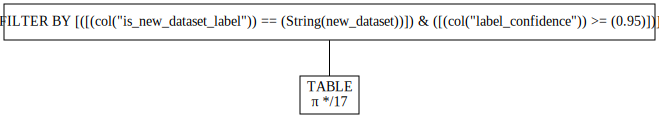

In [ ]:
df_predicted_as_new_dataset_high_confidence.show_graph()

In [ ]:
df_predicted_as_new_dataset_high_confidence.collect()

id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,prompt,is_new_dataset_label,label_confidence
str,str,str,str,str,str,str,str,str,str,str,list[struct[2]],datetime[ms],list[list[str]],str,str,f64
"""1209.0835""","""Neil Zhenqiang Gong""","""Neil Zhenqiang Gong, Wenchang …","""Evolution of Social-Attribute …","""14 pages, 19 figures. will app…",null,null,null,"""cs.SI cs.CY physics.soc-ph""","""http://arxiv.org/licenses/none…",""" Understanding social network…","[{""v1"",""Wed, 5 Sep 2012 01:01:47 GMT""}, {""v2"",""Sat, 8 Sep 2012 04:12:28 GMT""}, … {""v4"",""Wed, 19 Sep 2012 02:24:50 GMT""}]",2012-09-20 00:00:00,"[[""Gong"", ""Neil Zhenqiang"", """"], [""Xu"", ""Wenchang"", """"], … [""Song"", ""Dawn"", """"]]","""TITLE: Evolution of Social-Att…","""new_dataset""",0.968679
"""1207.0784""","""Romain Giot""","""Romain Giot (GREYC), Mohamad E…","""Web-Based Benchmark for Keystr…","""The Eighth International Confe…",null,null,null,"""cs.LG""","""http://arxiv.org/licenses/none…",""" Most keystroke dynamics stud…","[{""v1"",""Tue, 3 Jul 2012 19:12:56 GMT""}]",2012-07-04 00:00:00,"[[""Giot"", ""Romain"", … ""GREYC""], [""El-Abed"", ""Mohamad"", … ""GREYC""], [""Rosenberger"", ""Christophe"", … ""GREYC""]]","""TITLE: Web-Based Benchmark for…","""new_dataset""",0.966945
"""1205.2345""","""Salah A. Aly""","""Hossam Zawbaa and Salah A. Aly""","""Hajj and Umrah Event Recogniti…","""4 pages, 18 figures with 33 im…",null,null,null,"""cs.CV cs.CY""","""http://arxiv.org/licenses/none…",""" In this note, new Hajj and U…","[{""v1"",""Thu, 10 May 2012 19:10:18 GMT""}]",2012-05-11 00:00:00,"[[""Zawbaa"", ""Hossam"", """"], [""Aly"", ""Salah A."", """"]]","""TITLE: Hajj and Umrah Event Re…","""new_dataset""",0.973292
"""1110.2096""","""Philipp Herrmann""","""Philipp N. Herrmann, Dennis O.…","""Beating Irrationality: Does De…",null,null,null,null,"""cs.HC cs.CY cs.SI""","""http://arxiv.org/licenses/none…",""" In this research, we investi…","[{""v1"",""Mon, 10 Oct 2011 16:23:18 GMT""}, {""v2"",""Tue, 3 Apr 2012 15:34:53 GMT""}]",2012-04-04 00:00:00,"[[""Herrmann"", ""Philipp N."", """"], [""Kundisch"", ""Dennis O."", """"], [""Rahman"", ""Mohammad S."", """"]]","""TITLE: Beating Irrationality: …","""new_dataset""",0.960584
"""1201.6569""","""Robert Fink""","""Robert Fink, Larisa Han, Dan O…","""Aggregation in Probabilistic D…","""VLDB2012""","""Proceedings of the VLDB Endowm…",null,null,"""cs.DB""","""http://arxiv.org/licenses/none…",""" This paper presents a query …","[{""v1"",""Tue, 31 Jan 2012 15:10:34 GMT""}]",2012-02-01 00:00:00,"[[""Fink"", ""Robert"", """"], [""Han"", ""Larisa"", """"], [""Olteanu"", ""Dan"", """"]]","""TITLE: Aggregation in Probabil…","""new_dataset""",0.955361
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""1910.10470""","""Hans Pinckaers""","""Hans Pinckaers, Geert Litjens""","""Neural Ordinary Differential E…","""Accepted to 'Medical Imaging m…",null,null,null,"""eess.IV cs.CV""","""http://arxiv.org/licenses/none…",""" Automated medical image segm…","[{""v1"",""Wed, 23 Oct 2019 11:35:19 GMT""}]",2019-10-24 00:00:00,"[[""Pinckaers"", ""Hans"", """"], [""Litjens"", ""Geert"", """"]]","""TITLE: Neural Ordinary Differe…","""new_dataset""",0.960731
"""1910.10502""","""Maaike De Boer""","""Hella Haanstra and Maaike H. T…","""Opinion aspect extraction in D…",null,null,null,null,"""cs.CL cs.LG""","""http://arxiv.org/licenses/none…",""" Aspect extraction can be use…","[{""v1"",""Mon, 21 Oct 2019 09:33:09 GMT""}]",2019-10-24 00:00:00,"[[""Haanstra"", ""Hella"", """"], [""de Boer"", ""Maaike H. T."", """"]]","""TITLE: Opinion aspect extracti…","""new_dataset""",0.967287
"""1908.01671""","""Alice Baird""","""Alice Baird and Bjoern Schulle…","""Acoustic Sounds for Wellbeing:…",null,null,null,null,"""cs.SD eess.AS""","""http://arxiv.org/licenses/none…",""" The field of sound healing i…","[{""v1"",""Mon, 5 Aug 2019 15:01:17 GMT""}, {""v2"",""Mon, 21 Oct 2019 20:50:51 GMT""

## Conclusion

In this post we've seen how to use vLLM to scale inference for ModernBERT based classifier models. I'm personally still very excited about the potential of smaller classifier models for a wide range of tasks and it's really cool to see a very well known and used inference engine like vLLM extending it's capabilities to include this kind of model. I'd be excited to see more models like this being added to vLLM and also to see the comunity shipping cool new classifiers for curating/cleaning/organizing large datasets.
